> 교수님이 말씀해주신 3D 여러 조직 segment 하는 방법 UNETR이용

아래의 링크를 통해 튜토리얼 따라해볼 수 있음

https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/unetr_btcv_segmentation_3d.ipynb

> 이번 튜토리얼은 어떻게 UNTETP을 이용해 workflow를 훈련시키는 방법에 대해 만들어볼 예정

> 훈련 데이터 셋 : BTCV

> 여러 조직들에 대한 segment를 진행해보자

## 작업설명
### 이번 작업에서는 총 6가지의 작업을 할 것이고 아래의 작업 설명을 보자.
> 1. Transforms for dictionary format data.
->딕셔너리형태의 데이터로 변환

> 2. Define a new transform according to MONAI transform API.
->Monai API에 맞게끔 새로운 형태로 정의 

> 3. Load Nifti image with metadata, load a list of images and stack them.
-> Nifti 이미지를 로드시키고, 그 이미지들을 리스트로 만듦

> 4. Randomly adjust intensity for data augmentation.
-> data augmentation을 위해 intensity를 랜덤하게 조절해줌 

> 5. Cache IO and transforms to accelerate training and validation.
-> 훈련 및 확인을 가속화시켜 Input/Output형태를 저장한다. 

> 6. 3D UNETR model, DiceCE loss function, Mean Dice metric for multi-organ segmentation task.
-> 3D UNETR 과 DiceCE loss 함수, Dice metric 평균을 구해 segment의 성능을 확인하기 



### 데이터셋 주소
https://www.synapse.org/#!Synapse:syn3193805/wiki/217752 

#### <데이터 요약> 소화계 
1. subjects : 50 people, cancer people

2. Data type : CT scan 

3. Target : 13 abdominal organs (1. Spleen 2. Right Kidney 3. Left Kideny 4.Gallbladder 5.Esophagus 6. Liver 7. Stomach 8.Aorta 9. IVC 10. Portal and Splenic Veins 11. Pancreas 12 Right adrenal gland 13 Left adrenal gland.)

4. Modality : CT Size : 30, 3D vol (24 Training + 6 Testing)

5. Challenge(비교) : BTCV MICCAI Challenge



## 1. 작업 시작 

### 1-1. 설치환경 : Setup environment

In [1]:
%matplotlib inline
%pip install -q "monai-weekly[nibabel, tqdm, einops]"



You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### 1-2. 설치모듈 : Setup imports

In [2]:
import os
import shutil  
import tempfile 

import matplotlib.pyplot as plt 
from tqdm import tqdm 

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

import torch

print_config()


MONAI version: 1.2.dev2304
Numpy version: 1.23.3
Pytorch version: 1.13.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 9a57be5aab9f2c2a134768c0c146399150e247a0
MONAI __file__: /Users/choedaehyeon/Library/Python/3.9/lib/python/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.2
pandas version: 1.5.1
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional depe

### 2-1. 디렉토리 경로 가지고오기 : Setup data directory
MONAI_DATA_DIRECTORY 에서 데이터를 가지고 올것 

In [3]:
directory = os.environ.get('/Users/choedaehyeon/Monai/data')

root_dir = tempfile.mkdtemp() if directory is None else directory 
print(root_dir) 

/var/folders/5v/qstscrlx4tsddzht4m9xgdcm0000gn/T/tmpqv76fmfj


### 2-2. 데이터 training 및 검수 할 셋업 만들기 : Setup transforms for training and validation


In [4]:
#훈련할 변형 방법들 설정 
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)

#형태 어떻게 변형줄건지 
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

### 2-3. 데이터셋 다운로드해서 가지고 오고 포맷팅 시키기 : Download dataset and format in the folder.

1. Download dataset from here: https://www.synapse.org/#!Synapse:syn3193805/wiki/89480\n
2. Put images in the ./data/imagesTr
3. Put labels in the ./data/labelsTr
4. make JSON file accordingly: ./data/dataset_0.json

> 훈련데이터셋 20개, 테스트데이터셋 20개 


In [104]:
data_dir = "./data/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)
print(train_loader)
print(val_loader)

Loading dataset: 100%|██████████| 6/6 [00:00<00:00,  7.75it/s]

### 2-4. 데이터 로드한거 확인 : Check data shape and visualize

{'img0035.nii.gz': 39, 'img0036.nii.gz': 50, 'img0037.nii.gz': 70, 'img0038.nii.gz': 90, 'img0039.nii.gz': 110, 'img0040.nii.gz': 200}
image shape: torch.Size([1, 213, 213, 40]), label shape: torch.Size([1, 213, 213, 40])


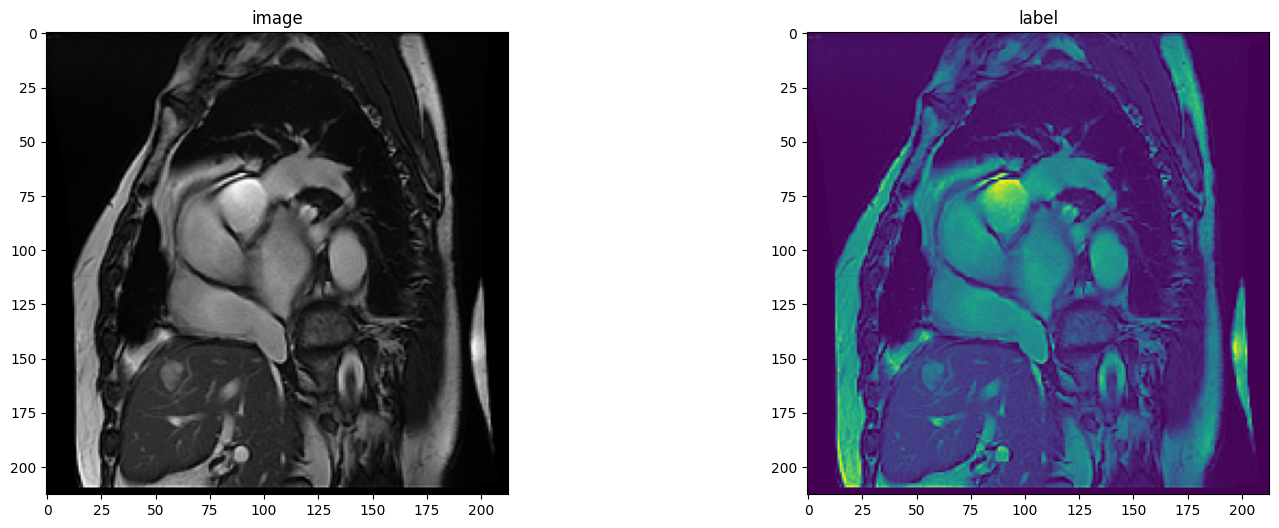

In [112]:
slice_map = { ##???????????????????????? 잘모르겟음 
    "img0035.nii.gz": 39,
    "img0036.nii.gz": 50,
    "img0037.nii.gz": 70,
    "img0038.nii.gz": 90,
    "img0039.nii.gz": 110,
    "img0040.nii.gz": 200,
}


print(slice_map)
case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### 2-5. 모델만들기 , 최적화, Loss 줄이기 : Create Model, Loss, Optimizer

In [113]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

### 2-6. pytorch 로 훈련 시키기 : Execute a typical PyTorch training process

In [114]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps)" % (global_step, 10.0)
            )
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(root_dir, "best_metric_model.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Training (X / X Steps) (loss=X.X):   0%|          | 0/24 [00:14<?, ?it/s]


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/choedaehyeon/Library/Python/3.9/lib/python/site-packages/monai/transforms/transform.py", line 105, in apply_transform
    return _apply_transform(transform, data, unpack_items)
  File "/Users/choedaehyeon/Library/Python/3.9/lib/python/site-packages/monai/transforms/transform.py", line 69, in _apply_transform
    return transform(parameters)
  File "/Users/choedaehyeon/Library/Python/3.9/lib/python/site-packages/monai/transforms/croppad/dictionary.py", line 860, in __call__
    self.randomize(label, fg_indices, bg_indices, image)
  File "/Users/choedaehyeon/Library/Python/3.9/lib/python/site-packages/monai/transforms/croppad/dictionary.py", line 851, in randomize
    self.cropper.randomize(label=label, fg_indices=fg_indices, bg_indices=bg_indices, image=image)
  File "/Users/choedaehyeon/Library/Python/3.9/lib/python/site-packages/monai/transforms/croppad/array.py", line 1058, in randomize
    self.centers = generate_pos_neg_label_crop_centers(
  File "/Users/choedaehyeon/Library/Python/3.9/lib/python/site-packages/monai/transforms/utils.py", line 523, in generate_pos_neg_label_crop_centers
    centers.append(correct_crop_centers(center, spatial_size, label_spatial_shape, allow_smaller))
  File "/Users/choedaehyeon/Library/Python/3.9/lib/python/site-packages/monai/transforms/utils.py", line 450, in correct_crop_centers
    raise ValueError("The size of the proposed random crop ROI is larger than the image size.")
ValueError: The size of the proposed random crop ROI is larger than the image size.

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/choedaehyeon/Library/Python/3.9/lib/python/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/Users/choedaehyeon/Library/Python/3.9/lib/python/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/choedaehyeon/Library/Python/3.9/lib/python/site-packages/torch/utils/data/_utils/fetch.py", line 58, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/choedaehyeon/Library/Python/3.9/lib/python/site-packages/monai/data/dataset.py", line 110, in __getitem__
    return self._transform(index)
  File "/Users/choedaehyeon/Library/Python/3.9/lib/python/site-packages/monai/data/dataset.py", line 924, in _transform
    data = apply_transform(_transform, data)
  File "/Users/choedaehyeon/Library/Python/3.9/lib/python/site-packages/monai/transforms/transform.py", line 132, in apply_transform
    raise RuntimeError(f"applying transform {transform}") from e
RuntimeError: applying transform <monai.transforms.croppad.dictionary.RandCropByPosNegLabeld object at 0x163a9e550>
